# TA2 - CNNs on FashionMNIST (Resumable + Traceable Version)

This notebook keeps the same training/tuning setup as the benchmark notebook,
but adds persistence so long runs can resume after interruptions.


In [3]:
import os
import json
import time
import random
import hashlib
import copy
from pathlib import Path
from typing import Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import optuna

from plot_utils import plot_random_raw_samples, plot_one_per_class

In [4]:
# Set the random seed for reproducibility
# np.random.seed() has a range of [0, 2**32 - 1] for the seed value
# print(np.random.randint(0, 2**32 - 1))  # Uncomment here for the first run to be a statistical purist
SEED = 4289813968  # Obviously your print is going to be something different


In [5]:
if torch.backends.mps.is_built() and torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(f'Using device: {DEVICE}')


Using device: mps


In [ ]:
DATA_ROOT = Path('../data')  # FashionMNIST will be stored in ../data/FashionMNIST
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
NUM_CLASSES = len(CLASS_NAMES)
VAL_RATIO = 0.10

MAX_EPOCHS = 15
FINAL_MAX_EPOCHS = 20
EARLY_STOPPING_PATIENCE = 4
N_TRIALS = 10
OPTUNA_TIMEOUT = None

NUM_WORKERS = min(4, os.cpu_count() or 1)
PIN_MEMORY = (DEVICE.type == 'cuda')
AMP_ENABLED = (DEVICE.type == 'cuda')

print(f'AMP enabled: {AMP_ENABLED}')

AMP enabled: False


In [7]:
RUN_MODE = 'resumable_with_checkpoints'
ENABLE_CHECKPOINTING = True

ARTIFACT_DIR = Path('session_2/artifacts/ta2_cnns_resumable')
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)
SPLIT_FILE = ARTIFACT_DIR / 'train_val_split.npz'

STUDY_NAME = 'ta2_cnns_resumable'
STUDY_DB = ARTIFACT_DIR / 'optuna_fashion_mnist.db'
STUDY_STORAGE = f'sqlite:///{STUDY_DB}'

print('Run mode:', RUN_MODE)
print('Checkpointing:', ENABLE_CHECKPOINTING)
print('Artifacts directory:', ARTIFACT_DIR.resolve())
print('Optuna DB:', STUDY_DB.resolve())


Run mode: resumable_with_checkpoints
Checkpointing: True
Artifacts directory: /Users/guillemmirabentrubinat/Documents/BSE/zz Teaching/Deep Learning/DL_TA_Sessions/session_2/session_2/artifacts/ta2_cnns_resumable
Optuna DB: /Users/guillemmirabentrubinat/Documents/BSE/zz Teaching/Deep Learning/DL_TA_Sessions/session_2/session_2/artifacts/ta2_cnns_resumable/optuna_fashion_mnist.db


## Resume Notes

If the run is interrupted:
1. Re-open notebook.
2. Run from top with same `ARTIFACT_DIR` and `STUDY_NAME`.
3. Optuna resumes from SQLite storage.
4. Trial/final checkpoints resume model state with minimal loss of progress.


In [8]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.benchmark = (DEVICE.type == 'cuda')

seed_everything(SEED)


## Data Loading and Raw Data Exploration

We inspect raw grayscale images and then build dataloaders with:
- augmentation on train only
- normalization on train/validation/test
- stratified split for class balance


In [9]:
raw_train = datasets.FashionMNIST(root=DATA_ROOT, train=True, download=True, transform=None)
raw_test = datasets.FashionMNIST(root=DATA_ROOT, train=False, download=True, transform=None)

print(f'Train size: {len(raw_train):,}')
print(f'Test size: {len(raw_test):,}')
print(f'Image shape: {raw_train[0][0].size} (grayscale)')


Train size: 60,000
Test size: 10,000
Image shape: (28, 28) (grayscale)


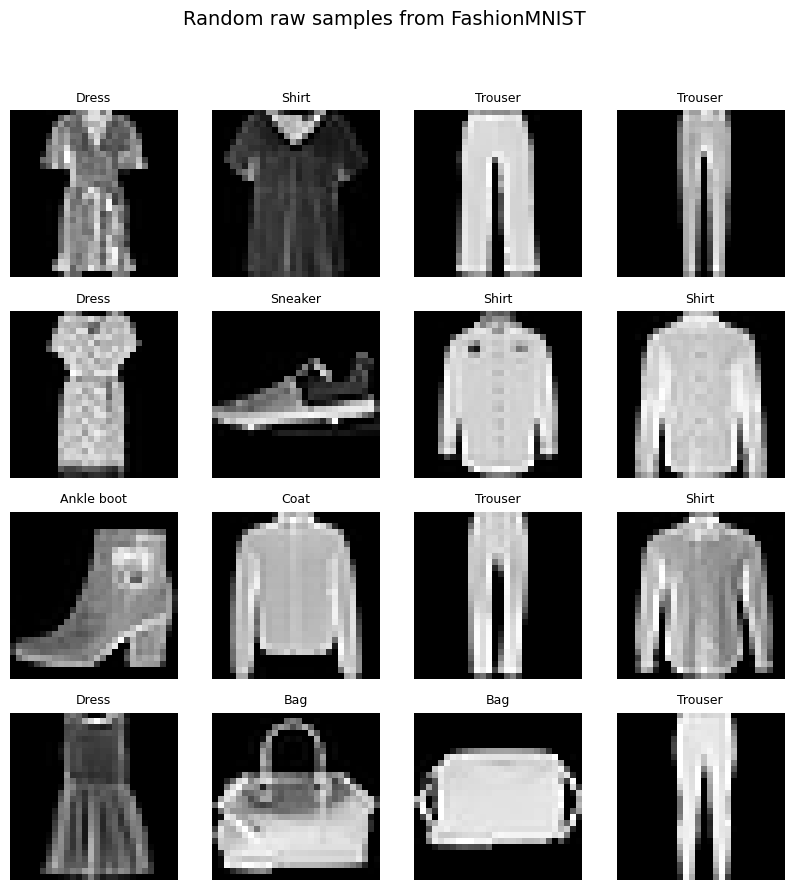

In [10]:
plot_random_raw_samples(raw_train, CLASS_NAMES, n=16, seed=SEED)

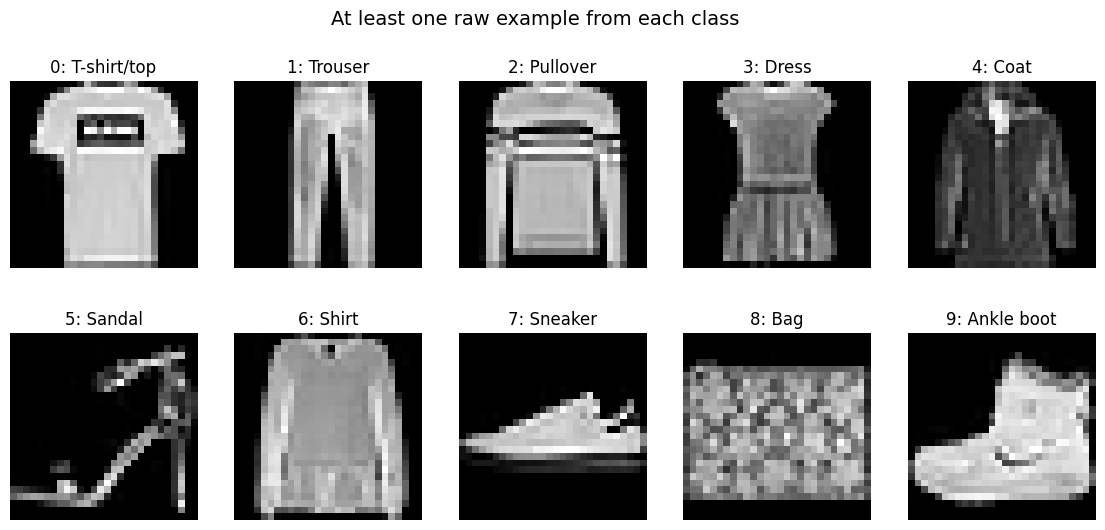

In [11]:
plot_one_per_class(raw_train, CLASS_NAMES)

In [12]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)),
])

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)),
])


def get_or_create_split_indices(targets: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    if SPLIT_FILE.exists():
        data = np.load(SPLIT_FILE)
        return data['train_idx'], data['val_idx']

    all_indices = np.arange(len(targets))
    train_idx, val_idx = train_test_split(
        all_indices,
        test_size=VAL_RATIO,
        random_state=SEED,
        stratify=targets,
        shuffle=True,
    )
    train_idx = np.sort(train_idx)
    val_idx = np.sort(val_idx)
    np.savez(SPLIT_FILE, train_idx=train_idx, val_idx=val_idx)
    return train_idx, val_idx


train_targets = np.array(raw_train.targets)
train_idx, val_idx = get_or_create_split_indices(train_targets)

train_dataset = datasets.FashionMNIST(root=DATA_ROOT, train=True, download=False, transform=train_transform)
val_dataset = datasets.FashionMNIST(root=DATA_ROOT, train=True, download=False, transform=eval_transform)
test_dataset = datasets.FashionMNIST(root=DATA_ROOT, train=False, download=False, transform=eval_transform)

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(val_dataset, val_idx)

print(f'Train subset size: {len(train_subset):,}')
print(f'Validation subset size: {len(val_subset):,}')
print(f'Test size: {len(test_dataset):,}')


def make_train_val_loaders(batch_size: int) -> tuple[DataLoader, DataLoader]:
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
    )
    return train_loader, val_loader


def make_test_loader(batch_size: int) -> DataLoader:
    return DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
    )

example_loader, _ = make_train_val_loaders(batch_size=128)
x_example, y_example = next(iter(example_loader))
print('Batch X shape:', tuple(x_example.shape))
print('Batch y shape:', tuple(y_example.shape))


## Simple CNN Architecture

This is intentionally straightforward for teaching:
- 3 convolution blocks
- batch normalization + ReLU
- max pooling in first two blocks
- global average pooling + dropout + linear classifier


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x


def count_trainable_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_preview = SimpleCNN(num_classes=NUM_CLASSES, dropout=0.3).to(DEVICE)
print(f'Trainable parameters: {count_trainable_parameters(model_preview):,}')
del model_preview


In [ ]:
def compute_epoch_metrics(y_true: list[int], y_pred: list[int]) -> dict[str, float]:
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'macro_f1': f1_score(y_true, y_pred, average='macro'),
    }


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    scaler: torch.amp.GradScaler,
) -> dict[str, float]:
    model.train()
    losses = []
    all_true, all_pred = [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if AMP_ENABLED:
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        all_true.extend(y.detach().cpu().tolist())
        all_pred.extend(torch.argmax(logits.detach(), dim=1).cpu().tolist())

    metrics = compute_epoch_metrics(all_true, all_pred)
    metrics['loss'] = float(np.mean(losses))
    return metrics


@torch.no_grad()
def evaluate_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
) -> tuple[dict[str, float], list[int], list[int]]:
    model.eval()
    losses = []
    all_true, all_pred = [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        if AMP_ENABLED:
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(x)
                loss = criterion(logits, y)
        else:
            logits = model(x)
            loss = criterion(logits, y)

        losses.append(loss.item())
        all_true.extend(y.detach().cpu().tolist())
        all_pred.extend(torch.argmax(logits.detach(), dim=1).cpu().tolist())

    metrics = compute_epoch_metrics(all_true, all_pred)
    metrics['loss'] = float(np.mean(losses))
    return metrics, all_true, all_pred


In [ ]:
def params_to_trial_id(params: dict[str, Any]) -> str:
    payload = json.dumps(params, sort_keys=True)
    return hashlib.sha1(payload.encode('utf-8')).hexdigest()[:12]


def save_json(path: Path, payload: dict[str, Any]) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(json.dumps(payload, indent=2))


def run_training(
    params: dict[str, Any],
    train_loader: DataLoader,
    val_loader: DataLoader,
    max_epochs: int,
    checkpoint_dir: Path | None = None,
    trial: optuna.trial.Trial | None = None,
) -> dict[str, Any]:
    model = SimpleCNN(num_classes=NUM_CLASSES, dropout=params['dropout']).to(DEVICE)
    criterion = nn.CrossEntropyLoss(label_smoothing=params['label_smoothing'])
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['weight_decay'],
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=max_epochs,
        eta_min=1e-6,
    )
    scaler = torch.amp.GradScaler('cuda', enabled=AMP_ENABLED)

    start_epoch = 0
    best_val_macro_f1 = -1.0
    best_state_dict = None
    epochs_without_improvement = 0
    history_rows: list[dict[str, float]] = []

    last_ckpt_path = None
    best_ckpt_path = None
    history_csv_path = None
    status_json_path = None

    if checkpoint_dir is not None:
        checkpoint_dir.mkdir(parents=True, exist_ok=True)
        save_json(checkpoint_dir / 'params.json', params)

        last_ckpt_path = checkpoint_dir / 'last.pt'
        best_ckpt_path = checkpoint_dir / 'best.pt'
        history_csv_path = checkpoint_dir / 'history.csv'
        status_json_path = checkpoint_dir / 'status.json'

        if status_json_path.exists():
            status_data = json.loads(status_json_path.read_text())
            if status_data.get('finished') and best_ckpt_path.exists():
                best_payload = torch.load(best_ckpt_path, map_location=DEVICE)
                model.load_state_dict(best_payload['model_state_dict'])
                model = model.to(DEVICE)
                history_df = pd.read_csv(history_csv_path) if history_csv_path.exists() else pd.DataFrame()
                return {
                    'model': model,
                    'history_df': history_df,
                    'best_val_macro_f1': float(status_data['best_val_macro_f1']),
                    'epochs_ran': int(status_data['epochs_ran']),
                }

        if last_ckpt_path.exists():
            payload = torch.load(last_ckpt_path, map_location=DEVICE)
            model.load_state_dict(payload['model_state_dict'])
            model = model.to(DEVICE)
            optimizer.load_state_dict(payload['optimizer_state_dict'])
            scheduler.load_state_dict(payload['scheduler_state_dict'])
            if payload.get('scaler_state_dict') is not None:
                scaler.load_state_dict(payload['scaler_state_dict'])
            start_epoch = int(payload['epoch']) + 1
            best_val_macro_f1 = float(payload['best_val_macro_f1'])
            epochs_without_improvement = int(payload['epochs_without_improvement'])
            history_rows = payload.get('history_rows', [])

    for epoch in range(start_epoch, max_epochs):
        train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
        val_metrics, _, _ = evaluate_one_epoch(model, val_loader, criterion)
        scheduler.step()

        row = {
            'epoch': epoch,
            'train_loss': train_metrics['loss'],
            'train_accuracy': train_metrics['accuracy'],
            'train_macro_f1': train_metrics['macro_f1'],
            'val_loss': val_metrics['loss'],
            'val_accuracy': val_metrics['accuracy'],
            'val_macro_f1': val_metrics['macro_f1'],
            'lr': float(optimizer.param_groups[0]['lr']),
        }
        history_rows.append(row)

        val_score = val_metrics['macro_f1']
        improved = val_score > (best_val_macro_f1 + 1e-4)
        if improved:
            best_val_macro_f1 = val_score
            best_state_dict = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if checkpoint_dir is not None:
            payload = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'scaler_state_dict': scaler.state_dict() if AMP_ENABLED else None,
                'best_val_macro_f1': best_val_macro_f1,
                'epochs_without_improvement': epochs_without_improvement,
                'history_rows': history_rows,
            }
            torch.save(payload, last_ckpt_path)

            if improved:
                torch.save({'model_state_dict': model.state_dict()}, best_ckpt_path)

            pd.DataFrame(history_rows).to_csv(history_csv_path, index=False)
            save_json(
                status_json_path,
                {
                    'finished': False,
                    'best_val_macro_f1': float(best_val_macro_f1),
                    'epochs_ran': int(len(history_rows)),
                },
            )

        if trial is not None:
            trial.report(val_score, step=epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned(f'Pruned at epoch {epoch}')

        if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
            break

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    elif best_ckpt_path is not None and best_ckpt_path.exists():
        best_payload = torch.load(best_ckpt_path, map_location=DEVICE)
        model.load_state_dict(best_payload['model_state_dict'])

    model = model.to(DEVICE)
    history_df = pd.DataFrame(history_rows)

    if checkpoint_dir is not None and status_json_path is not None:
        save_json(
            status_json_path,
            {
                'finished': True,
                'best_val_macro_f1': float(best_val_macro_f1),
                'epochs_ran': int(len(history_rows)),
            },
        )

    return {
        'model': model,
        'history_df': history_df,
        'best_val_macro_f1': float(best_val_macro_f1),
        'epochs_ran': int(len(history_rows)),
    }


## Hyperparameter Tuning with Optuna

We tune:
- learning rate
- weight decay
- dropout
- label smoothing
- batch size

Optimization target: **validation Macro-F1**.


In [ ]:
def suggest_params(trial: optuna.trial.Trial) -> dict[str, Any]:
    return {
        'lr': trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 5e-3, log=True),
        'dropout': trial.suggest_float('dropout', 0.10, 0.50),
        'label_smoothing': trial.suggest_float('label_smoothing', 0.0, 0.12),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
    }


def objective(trial: optuna.trial.Trial) -> float:
    params = suggest_params(trial)
    trial_id = params_to_trial_id(params)

    train_loader, val_loader = make_train_val_loaders(batch_size=params['batch_size'])
    trial_dir = ARTIFACT_DIR / 'trials' / trial_id

    result = run_training(
        params=params,
        train_loader=train_loader,
        val_loader=val_loader,
        max_epochs=MAX_EPOCHS,
        checkpoint_dir=trial_dir,
        trial=trial,
    )

    trial.set_user_attr('trial_id', trial_id)
    trial.set_user_attr('epochs_ran', result['epochs_ran'])
    trial.set_user_attr('trial_dir', str(trial_dir))
    return result['best_val_macro_f1']


In [ ]:
sampler = optuna.samplers.TPESampler(seed=SEED)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3)
storage = optuna.storages.RDBStorage(
    url=STUDY_STORAGE,
    heartbeat_interval=60,
    grace_period=180,
    failed_trial_callback=optuna.storages.RetryFailedTrialCallback(max_retry=2),
)

study = optuna.create_study(
    study_name=STUDY_NAME,
    storage=storage,
    load_if_exists=True,
    direction='maximize',
    sampler=sampler,
    pruner=pruner,
)

start_time = time.perf_counter()
study.optimize(objective, n_trials=N_TRIALS, timeout=OPTUNA_TIMEOUT, show_progress_bar=True)
search_minutes = (time.perf_counter() - start_time) / 60

print(f'Finished/loaded {len(study.trials)} trials in {search_minutes:.2f} minutes this session.')
print('Best validation Macro-F1:', round(study.best_value, 4))
print('Best params:', study.best_params)


In [ ]:
trials_df = study.trials_dataframe()
display(trials_df.sort_values('value', ascending=False).head(10))

plt.figure(figsize=(8, 4))
completed = trials_df[trials_df['state'] == 'COMPLETE']
plt.plot(completed['number'], completed['value'], marker='o')
plt.title('Validation Macro-F1 by completed trial')
plt.xlabel('Trial number')
plt.ylabel('Macro-F1')
plt.grid(True, alpha=0.3)
plt.show()


## Final Training and Out-of-Sample Evaluation

After tuning, we retrain with the best hyperparameters and evaluate on the held-out 10k test set.

Metrics:
- test loss
- test accuracy
- test Macro-F1
- per-class report
- confusion matrix


In [ ]:
best_params = study.best_trial.params.copy()
train_loader, val_loader = make_train_val_loaders(batch_size=best_params['batch_size'])

final_dir = ARTIFACT_DIR / 'final_model'
start_time = time.perf_counter()
final_result = run_training(
    params=best_params,
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=FINAL_MAX_EPOCHS,
    checkpoint_dir=final_dir,
    trial=None,
)
final_minutes = (time.perf_counter() - start_time) / 60

best_model = final_result['model'].to(DEVICE)
print(f'Final training finished in {final_minutes:.2f} minutes')
print('Best validation Macro-F1:', round(final_result['best_val_macro_f1'], 4))
print('Epochs used:', final_result['epochs_ran'])


In [ ]:
criterion_eval = nn.CrossEntropyLoss()
test_loader = make_test_loader(batch_size=best_params['batch_size'])
test_metrics, y_true_test, y_pred_test = evaluate_one_epoch(best_model, test_loader, criterion_eval)

print('Test metrics (out-of-sample):')
print(f"  Loss:      {test_metrics['loss']:.4f}")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Macro-F1:  {test_metrics['macro_f1']:.4f}")

print('\nPer-class report:')
print(classification_report(y_true_test, y_pred_test, target_names=CLASS_NAMES, digits=4))


In [ ]:
cm = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
)
plt.title('Test confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()


In [ ]:
summary = {
    'study_name': STUDY_NAME,
    'best_trial_number': int(study.best_trial.number),
    'best_validation_macro_f1': float(study.best_value),
    'best_params': study.best_params,
    'test_metrics': {
        'loss': float(test_metrics['loss']),
        'accuracy': float(test_metrics['accuracy']),
        'macro_f1': float(test_metrics['macro_f1']),
    },
}
summary_path = ARTIFACT_DIR / 'final_summary.json'
summary_path.write_text(json.dumps(summary, indent=2))
print('Saved summary to', summary_path.resolve())
